In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [111]:

def read_file(filename):
    return pd.read_csv(filename, index_col=0, parse_dates=True, infer_datetime_format=True)

def get_data(timeframe):
    return read_file("../../data/btcusdt_" + timeframe + ".csv")

time_frame = "5m"
# Load data
df = get_data(time_frame)
df.head()

,open,high,low,close,volume
datetime,,,,,
2018-01-01 05:30:00,13715.65,13715.65,13576.28,13600.00,33.617798
2018-01-01 05:35:00,13600.00,13600.00,13501.01,13554.58,40.528679
2018-01-01 05:40:00,13554.58,13569.97,13400.01,13556.15,49.469536
2018-01-01 05:45:00,13533.75,13547.73,13402.00,13430.52,32.725614
2018-01-01 05:50:00,13440.01,13459.99,13410.44,13439.94,26.614135


In [112]:
df['Daily_Return'] = df['close'].pct_change()
df['Next_Day_Return'] = df['Daily_Return'].shift(-1)
window = 14
delta = df['close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))
short_window = 12
long_window = 26
signal_window = 9
df['Short_MA'] = df['close'].rolling(window=short_window).mean()
df['Long_MA'] = df['close'].rolling(window=long_window).mean()
df['MACD'] = df['Short_MA'] - df['Long_MA']
df['Signal_Line'] = df['MACD'].rolling(window=signal_window).mean()
n = 5
df['ROC'] = df['close'].pct_change(n) * 100
df['OBV'] = np.where(df['close'] > df['close'].shift(1), df['volume'], -df['volume'])
df['OBV'] = df['OBV'].cumsum()
df_ = df.drop(['high', 'low', 'MACD', 'Short_MA', 'Long_MA'], axis=1)
df_ = df_.drop(df_.index[:50])
df_.head()

,open,close,volume,Daily_Return,Next_Day_Return,RSI,Signal_Line,ROC,OBV
datetime,,,,,,,,,
2018-01-01 09:40:00,13399.99,13351.71,32.528288,-0.003604,-0.001622,54.324571,67.078497,-1.024836,-179.183478
2018-01-01 09:45:00,13354.99,13330.05,36.474570,-0.001622,0.005922,48.449522,72.490605,-0.788405,-215.658048
2018-01-01 09:50:00,13336.98,13408.99,17.610242,0.005922,0.001567,47.130560,74.297678,-0.007755,-198.047806
2018-01-01 09:55:00,13408.99,13430.00,16.478325,0.001567,0.001143,47.790564,72.612650,0.022716,-181.569481
2018-01-01 10:00:00,13429.99,13445.35,24.084508,0.001143,0.001238,44.600351,67.715670,0.338433,-157.484973


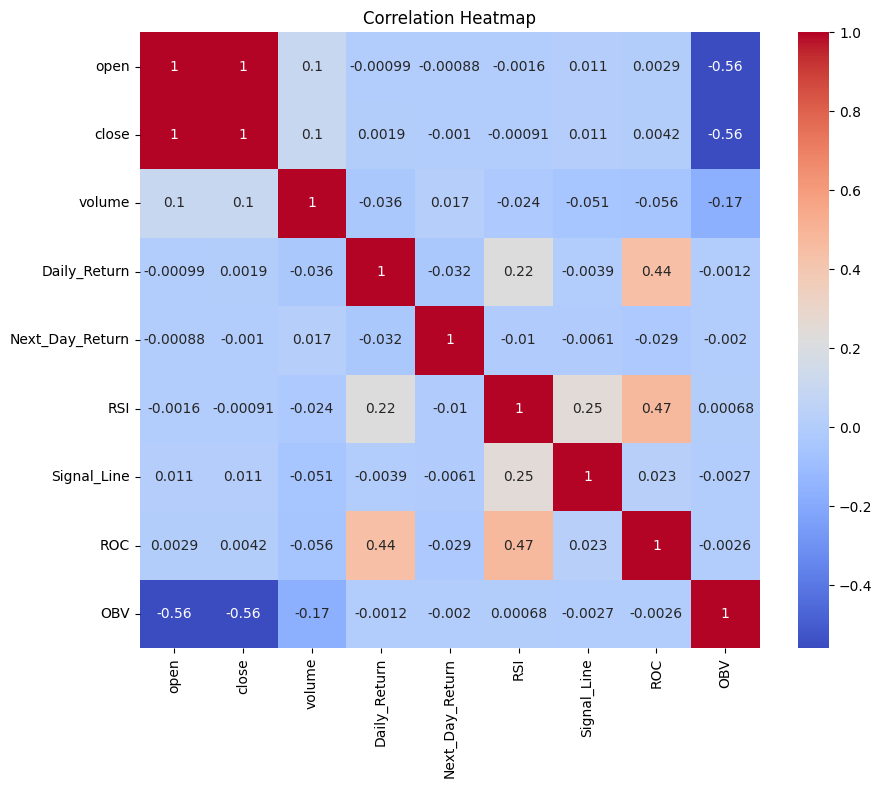

In [113]:

# Calculate the correlation matrix
correlation_matrix = df_.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [114]:
df_.to_csv("../logs/junk" + time_frame + ".csv")

In [115]:
from sklearn.linear_model import LinearRegression
# Import the necessary libraries

# Create the linear regression model
model = LinearRegression()

# Define the independent variables
print
X = df_.drop('Next_Day_Return', axis=1)
X = X.drop('open', axis=1)
X = X[X['volume'] != 0]
print(X.columns)

# Define the dependent variable
y = df_['Next_Day_Return']

df_['indicator'] = 0

# Iterate over the rows in the dataframe
for i in range(5100, len(df_)-1):
    # Select the past 100 rows as training data
    X_train = X.iloc[i-5000:i-1]
    y_train = y.iloc[i-5000:i-1]

    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the current row
    X_test = X.iloc[i:i+1]
    y_pred = model.predict(X_test)
    df_.loc[X_test.index, 'y_pred'] = y_pred
    
    if y_pred > 0:
        df_.loc[X_test.index, 'indicator'] = 1
    if y_pred < 0:
        df_.loc[X_test.index, 'indicator'] = -1

data = df_
tot = 0
for index, _ in data.iterrows():
    data.at[index, 'signal'] = 0
    if data.at[index, 'indicator'] == 1:
        if tot == 0 or tot == -1:
            # enter long position/exit short position
            tot += 1
            data.at[index, 'signal'] = 1
    elif data.at[index, 'indicator'] == -1:
        if tot == 0 or tot == 1:
            # enter short position/exit long position
            tot -= 1
            data.at[index, 'signal'] = -1
    else:
        if tot == 1:
            # exit long position
            data.at[index, 'signal'] = -1
        elif tot == -1:
            # exit short position
            data.at[index, 'signal'] = 1
        tot = 0

data.to_csv("../logs/lin_reg_" + time_frame + ".csv")

Index(['close', 'volume', 'Daily_Return', 'RSI', 'Signal_Line', 'ROC', 'OBV'], dtype='object')


In [ ]:
print(model.coef_)

[ 1.21847531e-08  2.41235571e-07 -3.14603606e-02  4.36085782e-06
 -1.00352071e-07 -1.54684330e-05 -7.83049520e-09]


In [ ]:
correlation = df_.iloc[300:]['Next_Day_Return'].corr(df_.iloc[300:]['y_pred'])
print(correlation)


-0.0155208800486485
